# 3: Image Classification
OBJECTIVE: to fine-tune two pre-trained ResNet50 models on the two balanced datasets (one through resampling, other through synthetic images), and evaluate performacne on test set
- Train 2 ResNet Models 
    - model_synth: fine-tuned classification model on synthetic balacned dataset
    - model_rep: fine-tuned classification model on resampling balanced dataset
- Save models
- Evaluate performance of two models, both on training set and testing set

In [1]:
import pandas as pd
import numpy as np
import torch.cuda as cuda
from torch.cuda import is_available
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from torch import device
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

SYNTH_MODEL_PATH = "model/state_dict_synth_model.pt"
REP_MODEL_PATH = "model/state_dict_rep_model.pt"

# Constants
BATCH_SIZE = 50
NUM_EPOCHS = 30
LABEL_TO_CLASS: dict = {
    'D': 0,
    'C': 1,
    'M': 2,
    'H': 3,
}
CLASS_TO_LABEL: dict = {
    0:'D',
    1:'C',
    2:'M',
    3:'H',
}
LABEL_TO_TITLE: dict = {
    'D': "Diabetes",
    'C': "Cataract",
    'H': "Hypertension",
    'M': "Pathological Myopia"
}
NUM_CLASSES: int = len(LABEL_TO_CLASS)
DEVICE = device("cuda" if is_available() else "cpu")
LEARNING_RATE: float = 0.0002

In [10]:
# Create CustomDataset Class
class CustomDataset(Dataset):
  def __init__(self, root_dir, label_file, transform=None, label="ALL"):
        self.root_dir = root_dir
        self.label_file = label_file
        self.transform = transform
        self.label = label
        if self.label == "ALL":
          self.labels_df = pd.read_csv(label_file)
        else: # only load images of the given label
          label_df = pd.read_csv(label_file)
          label_df = label_df[label_df['labels']==self.label].reset_index(drop=True)
          self.labels_df = label_df
        self.image_files = os.listdir(root_dir)

  def __len__(self):
    return len(self.labels_df)

  def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        # Extract label from the label file
        filename = self.image_files[idx]
        if self.label=='ALL':
          label = self.labels_df.loc[self.labels_df['filename'] == filename]['labels'].item()
        else:
          label = self.label
        # Convert label to label class, to get index for encoding
        label_ind = LABEL_TO_CLASS[label]
        # one hot encoding for labels:
        label_encoded = torch.zeros(NUM_CLASSES)
        label_encoded[label_ind] = 1

        return image, label_encoded

In [11]:
test_dataset = CustomDataset(root_dir='../data/test_imgs', label_file='../data/test_labels.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataset = CustomDataset(root_dir='../data/train_imgs', label_file='../data/train_labels.csv', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

synthetic_dataset = CustomDataset(root_dir='../data/train_synth_imgs', label_file='../data/train_synth_labels.csv', transform=transform)
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=BATCH_SIZE, shuffle=True)

repeating_dataset = CustomDataset(root_dir='../data/train_rep_imgs', label_file='../data/train_rep_labels.csv', transform=transform)
repeating_dataloader = DataLoader(repeating_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Evaluating Synth Model
# Lists to store predictions and ground truth labels
def evaluate_model(model, dataloader):

    # Set the model to evaluation mode
    model.eval()
    
    val_loss = []
    correct_predictions = 0

    criterion = nn.CrossEntropyLoss()

    # Disable gradient tracking during inference
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE) 
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs).to(DEVICE)


            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            correct_predictions += (outputs.argmax(dim=1)==labels.argmax(dim=1)).sum().item()


        # Store predictions and ground truth labels
        val_loss = np.mean(val_loss)
        val_acc = correct_predictions/len(dataloader.dataset)
            
    return val_loss, val_acc

## Train ResNet50 on Synthetic Dataset

In [34]:
# Define image classification model
model_synth = resnet50(pretrained=True)
num_ftrs = model_synth.fc.in_features
model_synth.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_synth = model_synth.to(DEVICE)


c:\Users\kidje\anaconda3\envs\rachaelenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kidje\anaconda3\envs\rachaelenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_synth.parameters(), lr=LEARNING_RATE)

synth_train_loss = []
synth_train_acc = []
synth_val_loss = []
synth_val_acc = []

# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    running_loss = []
    running_accuracy = 0.0
    for i, (imgs, labels) in enumerate(synthetic_dataloader):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward pass
        outputs = model_synth(imgs)
        #print(outputs.shape, label.shape)
        loss = criterion(outputs, labels)
        train_acc = (outputs.argmax(dim=1)==labels.argmax(dim=1)).sum()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        running_accuracy += train_acc.item()
    
    # Calculate average loss for the epoch
    epoch_loss = np.mean(running_loss)
    synth_train_loss.append(epoch_loss)

    epoch_accuracy = running_accuracy / len(synthetic_dataloader.dataset)
    synth_train_acc.append(epoch_accuracy)

    val_loss, val_acc = evaluate_model(model_synth, test_dataloader)
    synth_val_loss.append(val_loss)
    synth_val_acc.append(val_acc)

    print('EPOCH[%d] train loss: %.3f train acc: %.3f val loss: %.3f val acc: %.3f'  %
            (epoch, epoch_loss, epoch_accuracy, val_loss, val_acc))

print('Finished Training')

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH[0] train loss: 0.266 train acc: 0.920 val loss: 0.458 val acc: 0.881
EPOCH[1] train loss: 0.523 train acc: 0.813 val loss: 0.427 val acc: 0.885
EPOCH[2] train loss: 0.120 train acc: 0.965 val loss: 0.368 val acc: 0.907
EPOCH[3] train loss: 0.155 train acc: 0.955 val loss: 0.332 val acc: 0.885
EPOCH[4] train loss: 0.100 train acc: 0.972 val loss: 0.476 val acc: 0.859
EPOCH[5] train loss: 0.094 train acc: 0.971 val loss: 0.389 val acc: 0.899
EPOCH[6] train loss: 0.071 train acc: 0.978 val loss: 0.571 val acc: 0.885
EPOCH[7] train loss: 0.072 train acc: 0.977 val loss: 0.419 val acc: 0.894
EPOCH[8] train loss: 0.127 train acc: 0.962 val loss: 0.377 val acc: 0.890
EPOCH[9] train loss: 0.069 train acc: 0.978 val loss: 0.449 val acc: 0.890
EPOCH[10] train loss: 0.059 train acc: 0.980 val loss: 0.580 val acc: 0.872
EPOCH[11] train loss: 0.049 train acc: 0.984 val loss: 0.479 val acc: 0.877
EPOCH[12] train loss: 0.078 train acc: 0.976 val loss: 0.595 val acc: 0.863
EPOCH[13] train loss: 

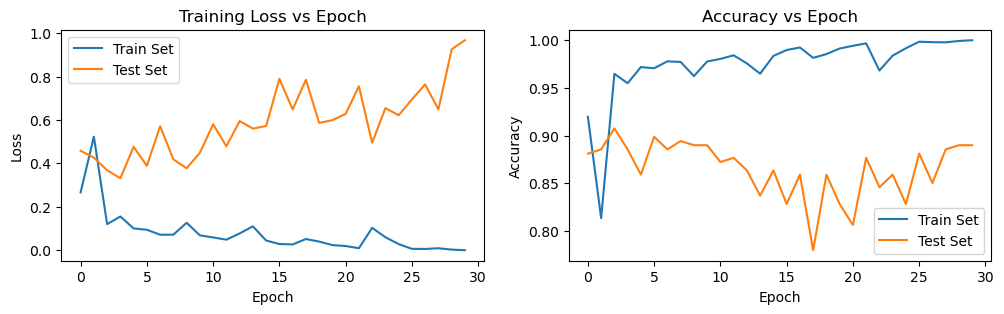

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
epoch_x = np.arange(0, NUM_EPOCHS)
ax[0].plot(epoch_x, synth_train_loss, label='Train Set')
ax[0].plot(epoch_x, synth_val_loss, label='Test Set')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training Loss vs Epoch")
ax[0].legend()

ax[1].plot(epoch_x, synth_train_acc, label='Train Set')
ax[1].plot(epoch_x, synth_val_acc, label='Test Set')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy vs Epoch")
ax[1].legend()

Save Model via state_dict

In [37]:
SYNTH_MODEL_PATH = "model/state_dict_synth_model.pt"

# Save
torch.save(model_synth.state_dict(), SYNTH_MODEL_PATH)

## Train ResNet50 on Resampling-Balanced Dataset

In [20]:
# Define image classification model
model_rep = resnet50(pretrained=True)
num_ftrs = model_rep.fc.in_features
model_rep.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_rep = model_rep.to(DEVICE)

c:\Users\kidje\anaconda3\envs\rachaelenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kidje\anaconda3\envs\rachaelenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rep.parameters(), lr=LEARNING_RATE)

rep_train_loss = []
rep_train_acc = []
rep_val_loss = []
rep_val_acc = []

# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    running_loss = []
    running_accuracy = 0.0
    for i, (imgs, labels) in enumerate(repeating_dataloader):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward pass
        outputs = model_rep(imgs)
        #print(outputs.shape, label.shape)
        loss = criterion(outputs, labels)
        train_acc = (outputs.argmax(dim=1)==labels.argmax(dim=1)).sum()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        running_accuracy += train_acc.item()
    
    # Calculate average loss for the epoch
    epoch_loss = np.mean(running_loss)
    rep_train_loss.append(epoch_loss)

    epoch_accuracy = running_accuracy / len(repeating_dataloader.dataset)
    rep_train_acc.append(epoch_accuracy)

    val_loss, val_acc = evaluate_model(model_rep, test_dataloader)
    rep_val_loss.append(val_loss)
    rep_val_acc.append(val_acc)

    print('EPOCH[%d] train loss: %.3f train acc: %.3f val loss: %.3f val acc: %.3f'  %
            (epoch, epoch_loss, epoch_accuracy, val_loss, val_acc))

print('Finished Training')

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH[0] train loss: 0.318 train acc: 0.878 val loss: 0.696 val acc: 0.802
EPOCH[1] train loss: 0.615 train acc: 0.730 val loss: 0.447 val acc: 0.863
EPOCH[2] train loss: 0.226 train acc: 0.911 val loss: 0.638 val acc: 0.775
EPOCH[3] train loss: 0.113 train acc: 0.961 val loss: 0.503 val acc: 0.872
EPOCH[4] train loss: 0.069 train acc: 0.979 val loss: 0.752 val acc: 0.819
EPOCH[5] train loss: 0.052 train acc: 0.983 val loss: 0.713 val acc: 0.824
EPOCH[6] train loss: 0.042 train acc: 0.988 val loss: 0.618 val acc: 0.877
EPOCH[7] train loss: 0.039 train acc: 0.988 val loss: 0.529 val acc: 0.899
EPOCH[8] train loss: 0.031 train acc: 0.990 val loss: 0.774 val acc: 0.877
EPOCH[9] train loss: 0.037 train acc: 0.987 val loss: 0.784 val acc: 0.872
EPOCH[10] train loss: 0.028 train acc: 0.990 val loss: 0.683 val acc: 0.863
EPOCH[11] train loss: 0.046 train acc: 0.987 val loss: 0.657 val acc: 0.850
EPOCH[12] train loss: 0.026 train acc: 0.992 val loss: 0.583 val acc: 0.859
EPOCH[13] train loss: 

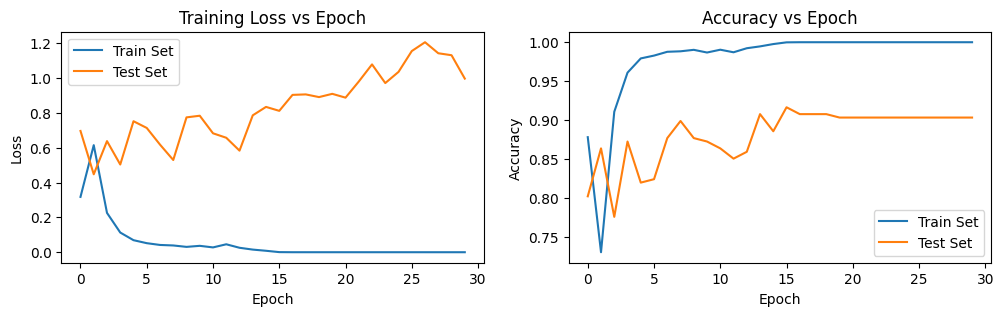

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
epoch_x = np.arange(0, NUM_EPOCHS)
ax[0].plot(epoch_x, rep_train_loss, label='Train Set')
ax[0].plot(epoch_x, rep_val_loss, label='Test Set')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training Loss vs Epoch")
ax[0].legend()

ax[1].plot(epoch_x, rep_train_acc, label='Train Set')
ax[1].plot(epoch_x, rep_val_acc, label='Test Set')
ax[1].set_xlabel("Epoch")
#ax[1].set_ylim([0,1])
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy vs Epoch")
ax[1].legend()

In [36]:
REP_MODEL_PATH = "model/state_dict_rep_model.pt"

# Save
torch.save(model_rep.state_dict(), REP_MODEL_PATH)

## Evaluating the Models

In [37]:
# Load in saved models
model_synth = resnet50(pretrained=True)
num_ftrs = model_synth.fc.in_features
model_synth.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_synth = model_synth.to(DEVICE)
model_synth.load_state_dict(torch.load(SYNTH_MODEL_PATH))
model_synth.eval()

model_rep = resnet50(pretrained=True)
num_ftrs = model_rep.fc.in_features
model_rep.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_rep = model_synth.to(DEVICE)
model_rep.load_state_dict(torch.load(REP_MODEL_PATH))
model_rep.eval()

c:\Users\kidje\anaconda3\envs\rachaelenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kidje\anaconda3\envs\rachaelenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
# Evaluating Model
def get_classification_report(model, dataloader):
    all_predictions = []
    all_labels = []
    selected_labels=['D', 'C', 'M', 'H']

    # Set the model to evaluation mode
    model.eval()


    # Disable gradient tracking during inference
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE) 

            # Forward pass
            outputs = model(inputs)

            # Get predicted labels
            predicted=outputs.argmax(dim=1)

            actual=labels.argmax(dim=1)

            # Store predictions and ground truth labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(list(actual))  # Convert labels to list
            
    #all_labels = [selected_labels.index(label) for label in all_labels]

    cf_matrix = ConfusionMatrixDisplay.from_predictions(all_labels, all_predictions, display_labels=selected_labels, normalize='true',cmap='terrain')

    report =classification_report(all_labels, all_predictions, labels=[0, 1, 2, 3], target_names=selected_labels)

    # Print classification report
    print(report)
    return report, cf_matrix


Synthetic Data-trained ResNet on Test Set Classification Report
              precision    recall  f1-score   support

           D       0.91      0.95      0.93       151
           C       0.88      0.85      0.86        41
           M       0.96      0.96      0.96        26
           H       0.33      0.11      0.17         9

    accuracy                           0.90       227
   macro avg       0.77      0.72      0.73       227
weighted avg       0.89      0.90      0.89       227


Synthetic Data-trained ResNet on Train Set Classification Report
              precision    recall  f1-score   support

           D       1.00      1.00      1.00      1457
           C       1.00      1.00      1.00       252
           M       1.00      1.00      1.00       206
           H       1.00      1.00      1.00       119

    accuracy                           1.00      2034
   macro avg       1.00      1.00      1.00      2034
weighted avg       1.00      1.00      1.00      2034



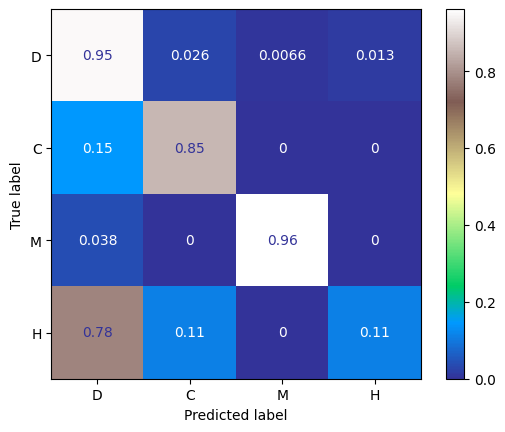

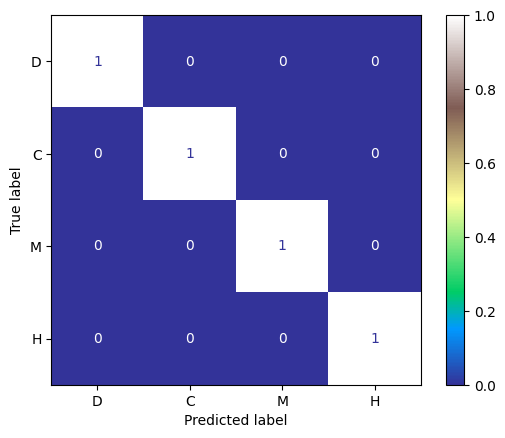

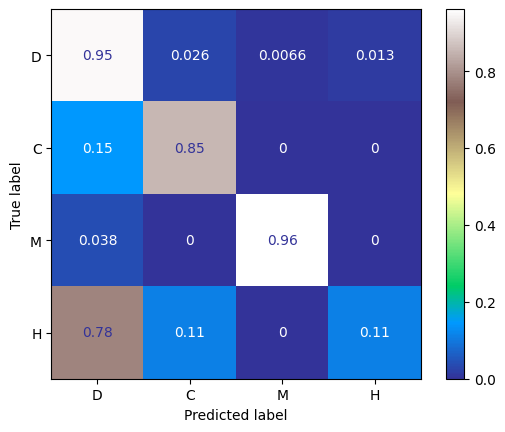

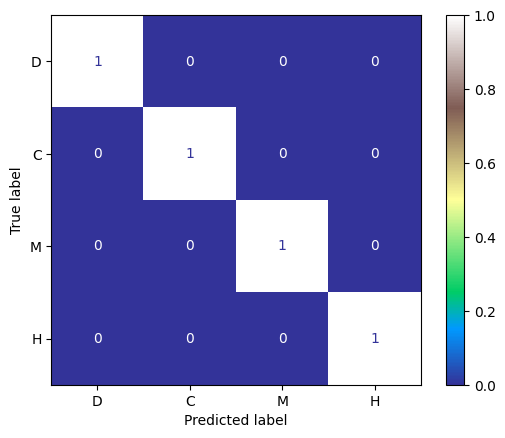

In [39]:
print("Synthetic Data-trained ResNet on Test Set Classification Report")
synth_test_report, synth_test_cm = get_classification_report(model_synth, test_dataloader)

print("\nSynthetic Data-trained ResNet on Train Set Classification Report")
synth_train_report, synth_train_cm = get_classification_report(model_synth, train_dataloader)

print("\n\nResampled Data-trained ResNet on Test Set Classification Report")
synth_test_report, rep_test_cm = get_classification_report(model_rep, test_dataloader)

print("\nResampled Data-trained ResNet on Train Set Classification Report")
synth_train_report, rep_train_cm = get_classification_report(model_rep, train_dataloader)